In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles,make_moons
from sklearn.neighbors import KernelDensity
from utils import GSW, MLP
import torch
import torch.optim as optim

In [3]:
device=torch.device('cpu')

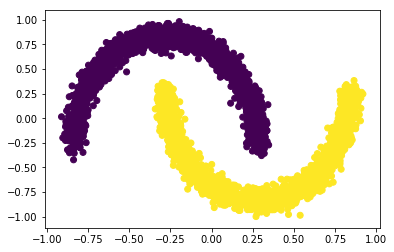

In [4]:
X, Y = make_moons(5000, noise=.05)
X[:, 1] *= 2
X -= X.mean(0)[np.newaxis, :]
X /= abs(X).max()

plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.show()

In [5]:
gridx, gridy = np.meshgrid(np.linspace(-1.2, 1.2, num=100), np.linspace(-1.2, 1.2, num=100))
gridvec = np.concatenate((np.reshape(gridx, (10000, 1)), np.reshape(gridy, (10000, 1))), 1)

In [6]:
ind = np.argwhere(Y == 0).squeeze()
z1 = X[ind, :].copy()
ind = np.argwhere(Y == 1).squeeze()
z2 = X[ind, :].copy()

# Density estimation on these two datasets
kde1 = KernelDensity(bandwidth=1e-1).fit(z1)
Z1 = np.exp(kde1.score_samples(gridvec)).reshape((100, 100))
kde2 = KernelDensity(bandwidth=1e-1).fit(z2)
Z2 = np.exp(kde2.score_samples(gridvec)).reshape((100, 100))

z1 = z1[:100, ...]
z2 = z2[:100, ...]

In [7]:
def plot_proj(gridx, gridy, Z1, Z2, z1, z2, z1proj, z2proj, fgridvec, title):
    N = 100
    l = 1.
    t = np.linspace(-1.2, 1.2, 101)

    fig = plt.figure(figsize=(10, 15))
    grid = plt.GridSpec(7, 7, wspace=.1, hspace=1.)

    plt.subplot(grid[:5, :])
    plt.contourf(gridx, gridy, Z1 + Z2, 5, cmap='gray')
    plt.contour(gridx, gridy, Z1, 3, colors='C0', linewidths=5, alpha=.4)
    plt.contour(gridx, gridy, Z2, 3, colors='C1', linewidths=5, alpha=.4)
    plt.contour(gridx, gridy, fgridvec,
                20, colors='orange', linewidths=3, linestyles='--', alpha=.75)
    plt.scatter(z1[:, 0], z1[:, 1], marker='X', c='C0', s=120)
    plt.scatter(z2[:, 0], z2[:, 1], marker='o', c='C1', s=100)

    plt.axis('square')
    plt.xticks([-1.2, 0, 1.2], [-1.2, 0, 1.2], fontsize=20)
    plt.yticks([-1.2, 0, 1.2], [-1.2, 0, 1.2], fontsize=20)

    plt.title(title, fontsize=28)

    plt.subplot(grid[5, :-2])
    plt.stem(z1proj, np.ones_like(z1proj) / float(N), markerfmt='X', linefmt='C0-')
    plt.stem(z2proj, np.ones_like(z2proj) / float(N), markerfmt='o', linefmt='C1-')
    #     plt.xlim([-1.5,1.5])
    plt.ylim([0, .02])
    plt.xticks(fontsize=15)
    plt.yticks([])
    plt.title(r'$\mathcal{R}\hat{p}_X(\cdot,\theta)$', fontsize=28)
    plt.legend([r'$x_n\cdot\theta$, $y_n=0$', r'$x_n\cdot\theta$, $y_n=1$'],
               fontsize=20, bbox_to_anchor=(1.0, 1.2))
    plt.xlabel(r'$t$', fontsize=24)

## Linear

In [8]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(solver='lbfgs')
classifier.fit(X, Y)
w = classifier.coef_
w /= np.sqrt(np.sum(w ** 2))

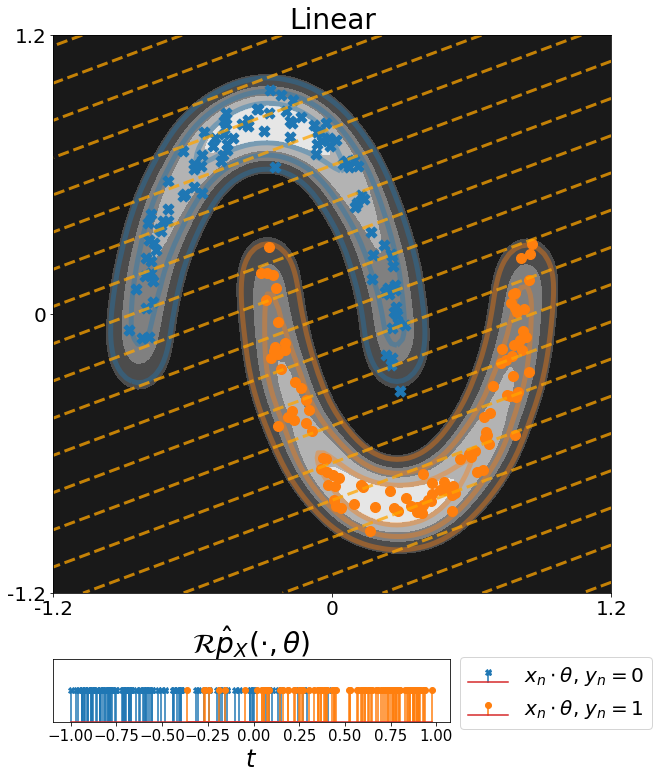

In [9]:
z1proj = np.matmul(z1, w.squeeze())
z2proj = np.matmul(z2, w.squeeze())
fgridvec = np.matmul(gridvec, w.squeeze()).reshape((100, 100))
plot_proj(gridx, gridy, Z1, Z2, z1, z2, z1proj, z2proj, fgridvec, 'Linear')

## Polynomial

In [10]:
modes = ['linear', 'poly', 'poly', 'poly']
degrees = [1, 3, 5, 7]

z1trch = torch.from_numpy(z1).type(torch.FloatTensor)
z2trch = torch.from_numpy(z2).type(torch.FloatTensor)

degree = 5
g = GSW(ftype='poly', degree=degree, nofprojections=1, use_cuda=False)
g.gsw(z1trch, z2trch)

tensor(3.9649)

In [12]:
def get_powers(dim,degree):
    '''
    This function calculates the powers of a homogeneous polynomial
    e.g.

    list(get_powers(dim=2,degree=3))
    [(0, 3), (1, 2), (2, 1), (3, 0)]

    list(get_powers(dim=3,degree=2))
    [(0, 0, 2), (0, 1, 1), (0, 2, 0), (1, 0, 1), (1, 1, 0), (2, 0, 0)]
    '''
    if dim == 1:
        yield (degree,)
    else:
        for value in range(degree + 1):
            for permutation in get_powers(dim - 1,degree - value):
                yield (value,) + permutation


def homopoly(dim,degree):
    '''
    calculates the number of elements in the summation of homogeneous 
    polynomials of odd degrees< degree

    '''
    d=0
    oddlist=np.arange(degree+1)
    oddlist=oddlist[np.argwhere(np.mod(oddlist,2)==1)]
    for a in oddlist:
        d+=len(list(get_powers(dim,a.squeeze())))    
        
    return d


def poly_kernel(X,degree):
    ''' The polynomial defining function for generalized Radon transform
        Inputs
        X:  Nxd matrix of N data samples
        theta: Lxd vector that parameterizes for L projections
        degree: degree of the polynomial
    '''
    N,d=X.shape
    dhomopoly=homopoly(d,degree)

    oddlist=np.arange(degree+1)
    oddlist=oddlist[np.argwhere(np.mod(oddlist,2)==1)]

    HX=np.ones((N,dhomopoly)).astype('float')
    
    powers=list()
    for n,a in enumerate(oddlist):
        powers.append(list(get_powers(d,a.squeeze())))
    powers=np.concatenate(powers)

    for k,power in enumerate(powers):
        for i,p in enumerate(power):
            HX[:,k]*=(X[:,i]**float(p))
    return HX

In [13]:
zH1 = poly_kernel(z1, degree)
zH2 = poly_kernel(z2, degree)
classifier = LogisticRegression(solver='lbfgs')
classifier.fit(np.concatenate([zH1, zH2]), np.concatenate([np.zeros(zH1.shape[0]), np.ones(zH2.shape[0])]))

w = classifier.coef_
w /= np.sqrt(np.sum(w ** 2))

g.theta.data = torch.from_numpy(w.copy()).type(torch.FloatTensor)

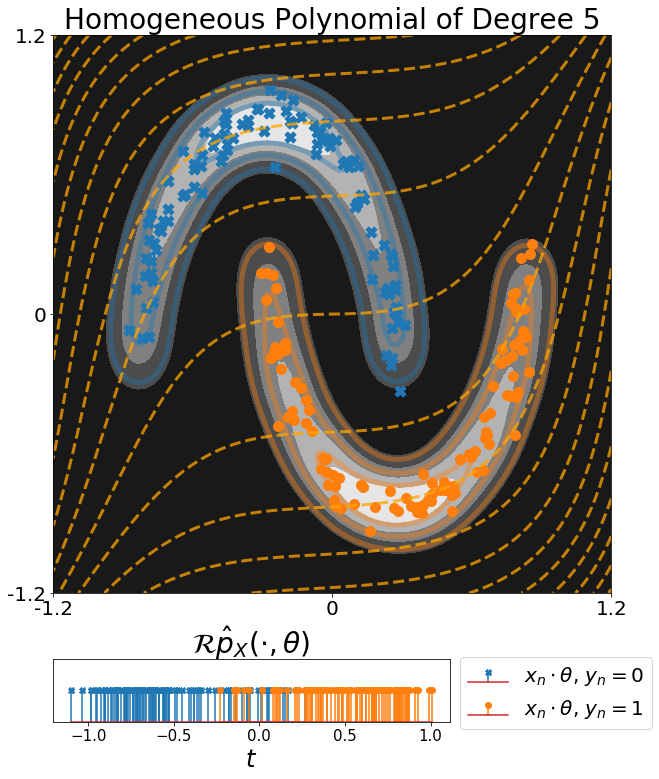

In [14]:
title = 'Homogeneous Polynomial of Degree 5'

z1proj = g.get_slice(z1trch, g.theta).detach().cpu().numpy()
z2proj = g.get_slice(z2trch, g.theta).detach().cpu().numpy()
fgridvec = g.get_slice(torch.from_numpy(gridvec).type(torch.FloatTensor), g.theta).reshape((100, 100))
fgridvec = fgridvec.detach().cpu().numpy()
plot_proj(gridx, gridy, Z1, Z2, z1, z2, z1proj, z2proj, fgridvec, title)

## Neural Network

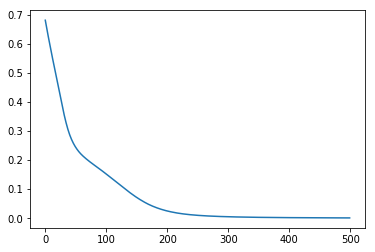

In [15]:
iterations = 500
model = MLP(din=2, dout=2, num_filters=64, depth=2)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
total_loss = np.zeros((iterations,))
criterion = torch.nn.CrossEntropyLoss()

xin = torch.cat([z1trch, z2trch])
yin = torch.cat([torch.zeros((z1trch.shape[0])),
                 torch.ones((z2trch.shape[0]))]).type(torch.LongTensor)

for i in range(iterations):
    optimizer.zero_grad()
    z = model(xin)
    loss = criterion(z, yin)
    total_loss[i] = loss.item()
    loss.backward()
    optimizer.step()

plt.plot(total_loss)
plt.show()

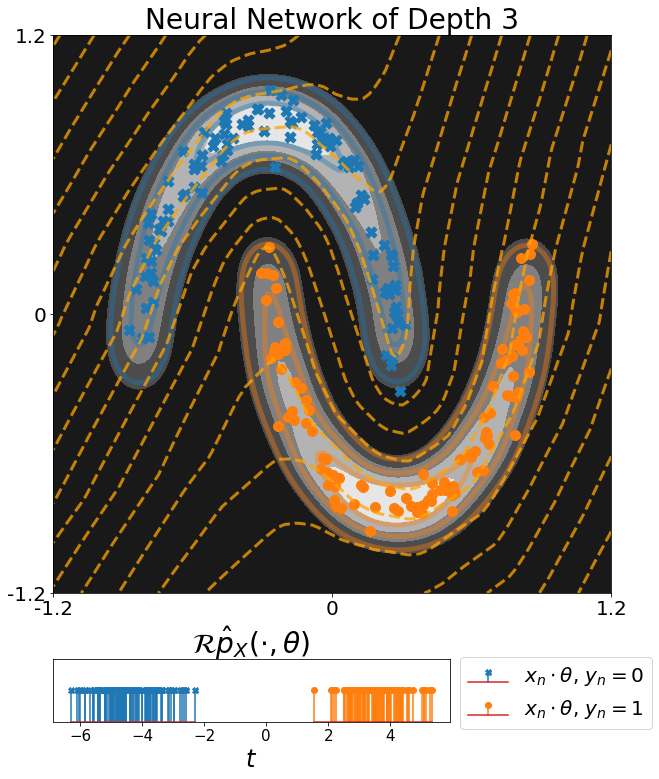

In [16]:
title = 'Neural Network of Depth 3'

z1proj = model(z1trch)[:, 1].detach().cpu().numpy()
z2proj = model(z2trch)[:, 1].detach().cpu().numpy()
fgridvec = model(torch.from_numpy(gridvec).type(torch.FloatTensor))[:, 1].reshape((100, 100))
fgridvec = fgridvec.detach().cpu().numpy()
plot_proj(gridx, gridy, Z1, Z2, z1, z2, z1proj, z2proj, fgridvec, title)

## Circular

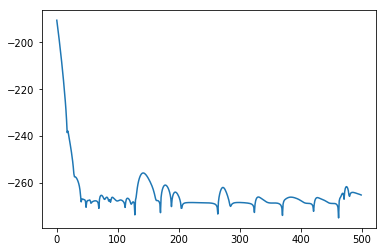

In [17]:
theta = torch.tensor(np.random.randn(2, ), dtype=torch.float, device='cpu', requires_grad=True)
optimizer = optim.Adam([theta], lr=1e-2)
total_loss = np.zeros((iterations,))
criterion = torch.nn.CrossEntropyLoss()
for i in range(iterations):
    optimizer.zero_grad()
    z = torch.sum((xin - theta) ** 2, 1)
    loss = torch.sum(-2 * (yin.type(torch.FloatTensor) - .5) * torch.log(z))
    total_loss[i] = loss.item()
    loss.backward()
    optimizer.step()
plt.plot(total_loss)
plt.show()

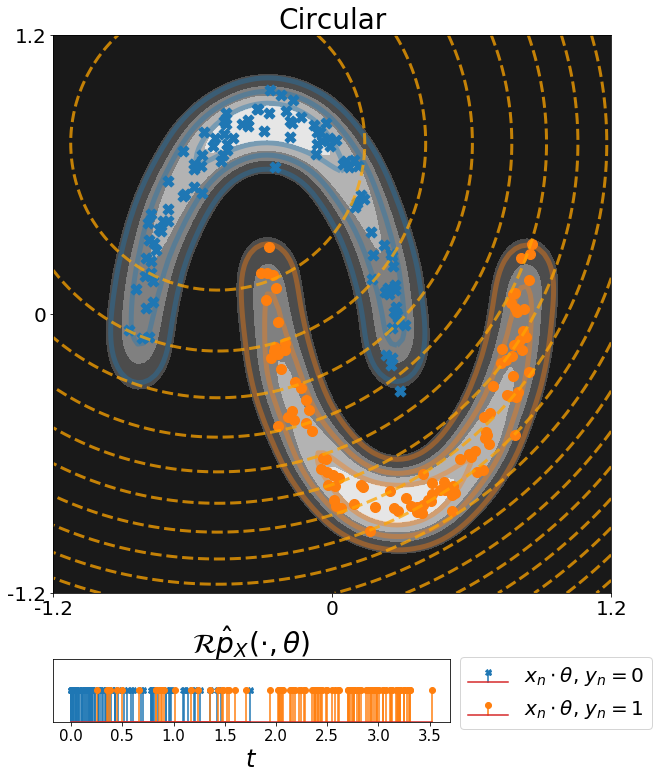

In [18]:
title = 'Circular'
theta = theta.detach().cpu().numpy()
z1proj = np.sum((z1 - theta) ** 2, 1)
z2proj = np.sum((z2 - theta) ** 2, 1)
fgridvec = np.sum((gridvec - theta) ** 2, 1).reshape((100, 100))
plot_proj(gridx, gridy, Z1, Z2, z1, z2, z1proj, z2proj, fgridvec, title)